In [30]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import re
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
import joblib



from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from models.train_classifier import tokenize

from sklearn import preprocessing

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\polys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\polys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\polys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
db_path=r'data/DisasterResponse.db'

In [6]:
# load data from database
engine = create_engine(f'sqlite:///{db_path}')

In [7]:
engine

Engine(sqlite:///data/DisasterResponse.db)

In [52]:
df = pd.read_sql("SELECT * FROM DisasterResponse",engine)
df.index=df['id']
X = df[['message','original','genre']]
categories= df.drop(columns=['id','message','original','genre']).columns

In [53]:
categories

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

<AxesSubplot:>

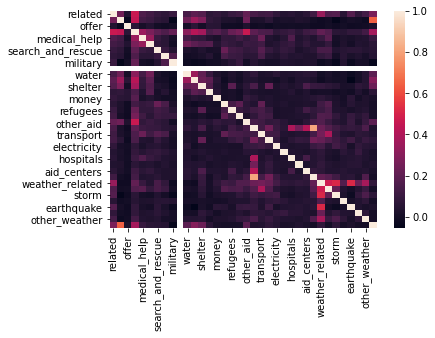

In [13]:
sns.heatmap(Y.corr())

In [55]:
df

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
8,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
12,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30261,30261,The training demonstrated how to enhance micro...,None,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30262,30262,A suitable candidate has been selected and OCH...,None,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30263,30263,"Proshika, operating in Cox's Bazar municipalit...",None,news,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
df[categories].sum().sort_values(ascending=False)

Index(['related', 'aid_related', 'weather_related', 'direct_report', 'request',
       'other_aid', 'food', 'earthquake', 'storm', 'shelter', 'floods',
       'medical_help', 'infrastructure_related', 'water', 'other_weather',
       'buildings', 'medical_products', 'transport', 'death',
       'other_infrastructure', 'refugees', 'military', 'search_and_rescue',
       'money', 'electricity', 'cold', 'security', 'clothing', 'aid_centers',
       'missing_people', 'hospitals', 'fire', 'tools', 'shops', 'offer',
       'child_alone'],
      dtype='object')

In [62]:
grouped_df=df.groupby('genre')[categories].sum().reset_index()

In [64]:
grouped_df

,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,direct,7314,3696,46,4338,592,471,216,131,46,...,78,186,1521,304,315,41,796,63,207,3613
1,news,10689,604,65,5860,1415,793,441,292,801,...,218,866,4280,1747,1445,225,910,415,1052,852
2,social,2090,174,7,662,77,49,67,48,13,...,13,99,1496,104,683,16,749,52,117,610


In [71]:
melted_df=pd.melt(grouped_df,id_vars='genre',value_vars=categories,var_name='category',value_name='count')

In [72]:
melted_df

,genre,category,count
0,direct,related,7314
1,news,related,10689
2,social,related,2090
3,direct,request,3696
4,news,request,604
...,...,...,...
103,news,other_weather,1052
104,social,other_weather,117
105,direct,direct_report,3613
106,news,direct_report,852


<AxesSubplot:xlabel='category', ylabel='count'>

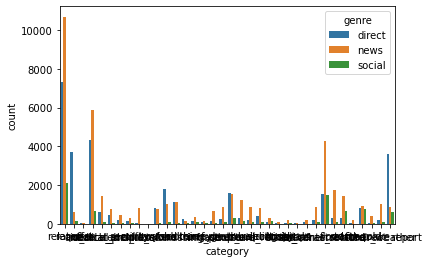

In [76]:
sns.barplot(x='category',y='count',data=melted_df,hue='genre')